In [51]:

import numpy as np
import pandas as pd
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from collections import Counter
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.sklearn import metrics

#from common_utils import compute_metrics

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]



#Load the data
adult_data = pd.read_csv('C:/Users/thano/Υπολογιστής/ΠΤΥΧΙΑΚΗ/DATASETS/adult.csv',sep= ',', header= 0)

In [52]:
print ("Dataset Lenght:: ", len(adult_data))
print ("Dataset Shape:: ", adult_data.shape)
#adult_data.sample(50)


print ("Rows     : " ,adult_data.isnull().shape[0])
print ("Columns  : " ,adult_data.isnull().shape[1])
print ("\nMissing values :  ", adult_data.isnull().sum().values.sum())



Dataset Lenght::  32561
Dataset Shape::  (32561, 15)
Rows     :  32561
Columns  :  15

Missing values :   0


In [53]:
#replace ? with NaN
adult_data = adult_data.replace('?', np.nan)
adult_data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [54]:
#drop the missing values
adult_data = adult_data.dropna()
adult_data.head()


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


In [55]:
#remove column 'fnlwgt' because it's not strongly connected to protected attributes
adult_data = adult_data.drop("fnlwgt", axis=1)
#adult_data = adult_data.drop("capital.gain", axis=1)

In [56]:
# rename the other values except White value in race column for future use
adult_data['race']= adult_data['race'].replace(['Black','Asian-Pac-Islander', 'Amer-Indian-Eskimo'], 'Other')
adult_data.head(10)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
7,74,State-gov,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
8,68,Federal-gov,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
10,45,Private,Doctorate,16,Divorced,Prof-specialty,Unmarried,Other,Female,0,3004,35,United-States,>50K
11,38,Self-emp-not-inc,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,2824,45,United-States,>50K
12,52,Private,Bachelors,13,Widowed,Other-service,Not-in-family,White,Female,0,2824,20,United-States,>50K


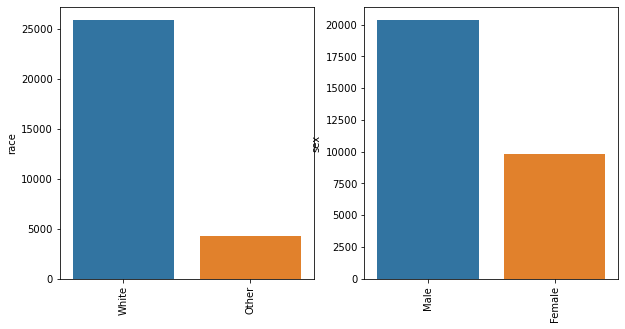

In [57]:
#plot the categorical count of each protected category
lis2 = ['race', 'sex']
plt.subplots(figsize=(10, 5))
index = 1
  
for col in lis2:
    y = adult_data[col].value_counts()
    plt.subplot(1, 2, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

In [58]:
# select all categorical variables
adult_data_categorical = adult_data.select_dtypes(include=['object'])
adult_data_categorical.head()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K
5,Private,HS-grad,Divorced,Other-service,Unmarried,White,Female,United-States,<=50K
6,Private,10th,Separated,Adm-clerical,Unmarried,White,Male,United-States,<=50K


In [59]:
# apply label encoder to categorical values
le = preprocessing.LabelEncoder()
adult_data_categorical = adult_data_categorical.apply(le.fit_transform)
adult_data_categorical.head()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
1,2,11,6,3,1,1,0,38,0
3,2,5,0,6,4,1,0,38,0
4,2,15,5,9,3,1,0,38,0
5,2,11,0,7,4,1,0,38,0
6,2,0,5,0,4,1,1,38,0


In [60]:
#Drop earlier duplicate columns which had categorical values and concat with new labelled categories (cd function)
adult_data = adult_data.drop(adult_data_categorical.columns,axis=1)
adult_data = pd.concat([adult_data,adult_data_categorical],axis=1)
adult_data.head()

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
1,82,9,0,4356,18,2,11,6,3,1,1,0,38,0
3,54,4,0,3900,40,2,5,0,6,4,1,0,38,0
4,41,10,0,3900,40,2,15,5,9,3,1,0,38,0
5,34,9,0,3770,45,2,11,0,7,4,1,0,38,0
6,38,6,0,3770,40,2,0,5,0,4,1,1,38,0


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


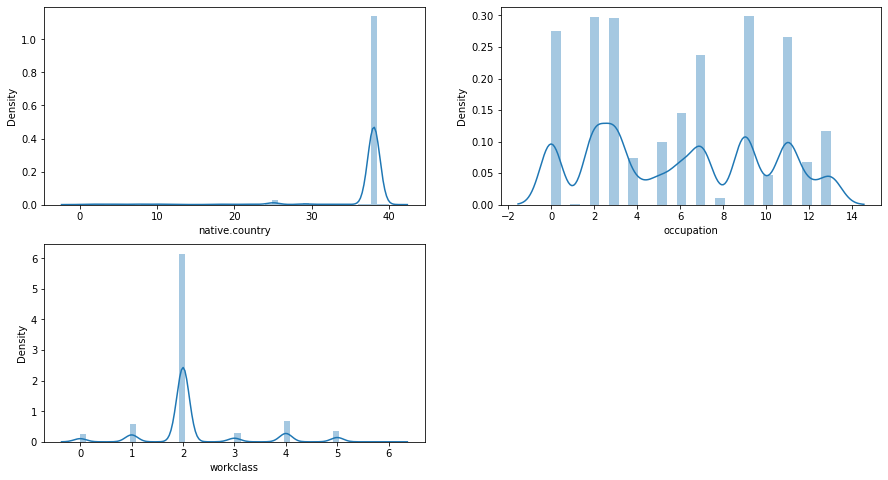

In [11]:
#plot the distributions
lis = ['native.country', 'occupation', 'workclass']
plt.subplots(figsize=(15, 8))
index = 1
  
for i in lis:
    plt.subplot(2, 2, index)
    sns.distplot(adult_data[i])
    index += 1

In [12]:
#Pearson correlations
pearson = adult_data.corr(method = 'pearson')
pearson

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
age,1.000000,0.043526,0.080154,0.060165,0.101599,0.080540,-0.001111,-0.276373,-0.005682,-0.246456,0.026906,0.081993,-0.001905,0.241998
education.num,0.043526,1.000000,0.124416,0.079646,0.152522,0.037833,0.345410,-0.063419,0.087717,-0.091935,0.052615,0.006157,0.091555,0.335286
capital.gain,0.080154,0.124416,1.000000,-0.032229,0.080432,0.035350,0.030575,-0.042418,0.022162,-0.058259,0.016933,0.048814,0.008530,0.221196
capital.loss,0.060165,0.079646,-0.032229,1.000000,0.052417,0.007204,0.015028,-0.035203,0.014607,-0.063567,0.026197,0.047011,0.009386,0.150053
hours.per.week,0.101599,0.152522,0.080432,0.052417,1.000000,0.050724,0.059887,-0.189003,0.018365,-0.257850,0.056404,0.231268,0.008408,0.229480
workclass,0.080540,0.037833,0.035350,0.007204,0.050724,1.000000,0.017855,-0.034241,0.015572,-0.067417,0.053950,0.074973,0.007668,0.018044
education,-0.001111,0.345410,0.030575,0.015028,0.059887,0.017855,1.000000,-0.040664,-0.038212,-0.012717,0.017646,-0.027888,0.078790,0.078987
marital.status,-0.276373,-0.063419,-0.042418,-0.035203,-0.189003,-0.034241,-0.040664,1.000000,0.022655,0.177964,-0.080166,-0.119813,-0.025902,-0.193518
occupation,-0.005682,0.087717,0.022162,0.014607,0.018365,0.015572,-0.038212,0.022655,1.000000,-0.053727,0.000905,0.062313,-0.003483,0.051577
relationship,-0.246456,-0.091935,-0.058259,-0.063567,-0.257850,-0.067417,-0.012717,0.177964,-0.053727,1.000000,-0.132612,-0.584876,-0.010809,-0.251003


<AxesSubplot:>

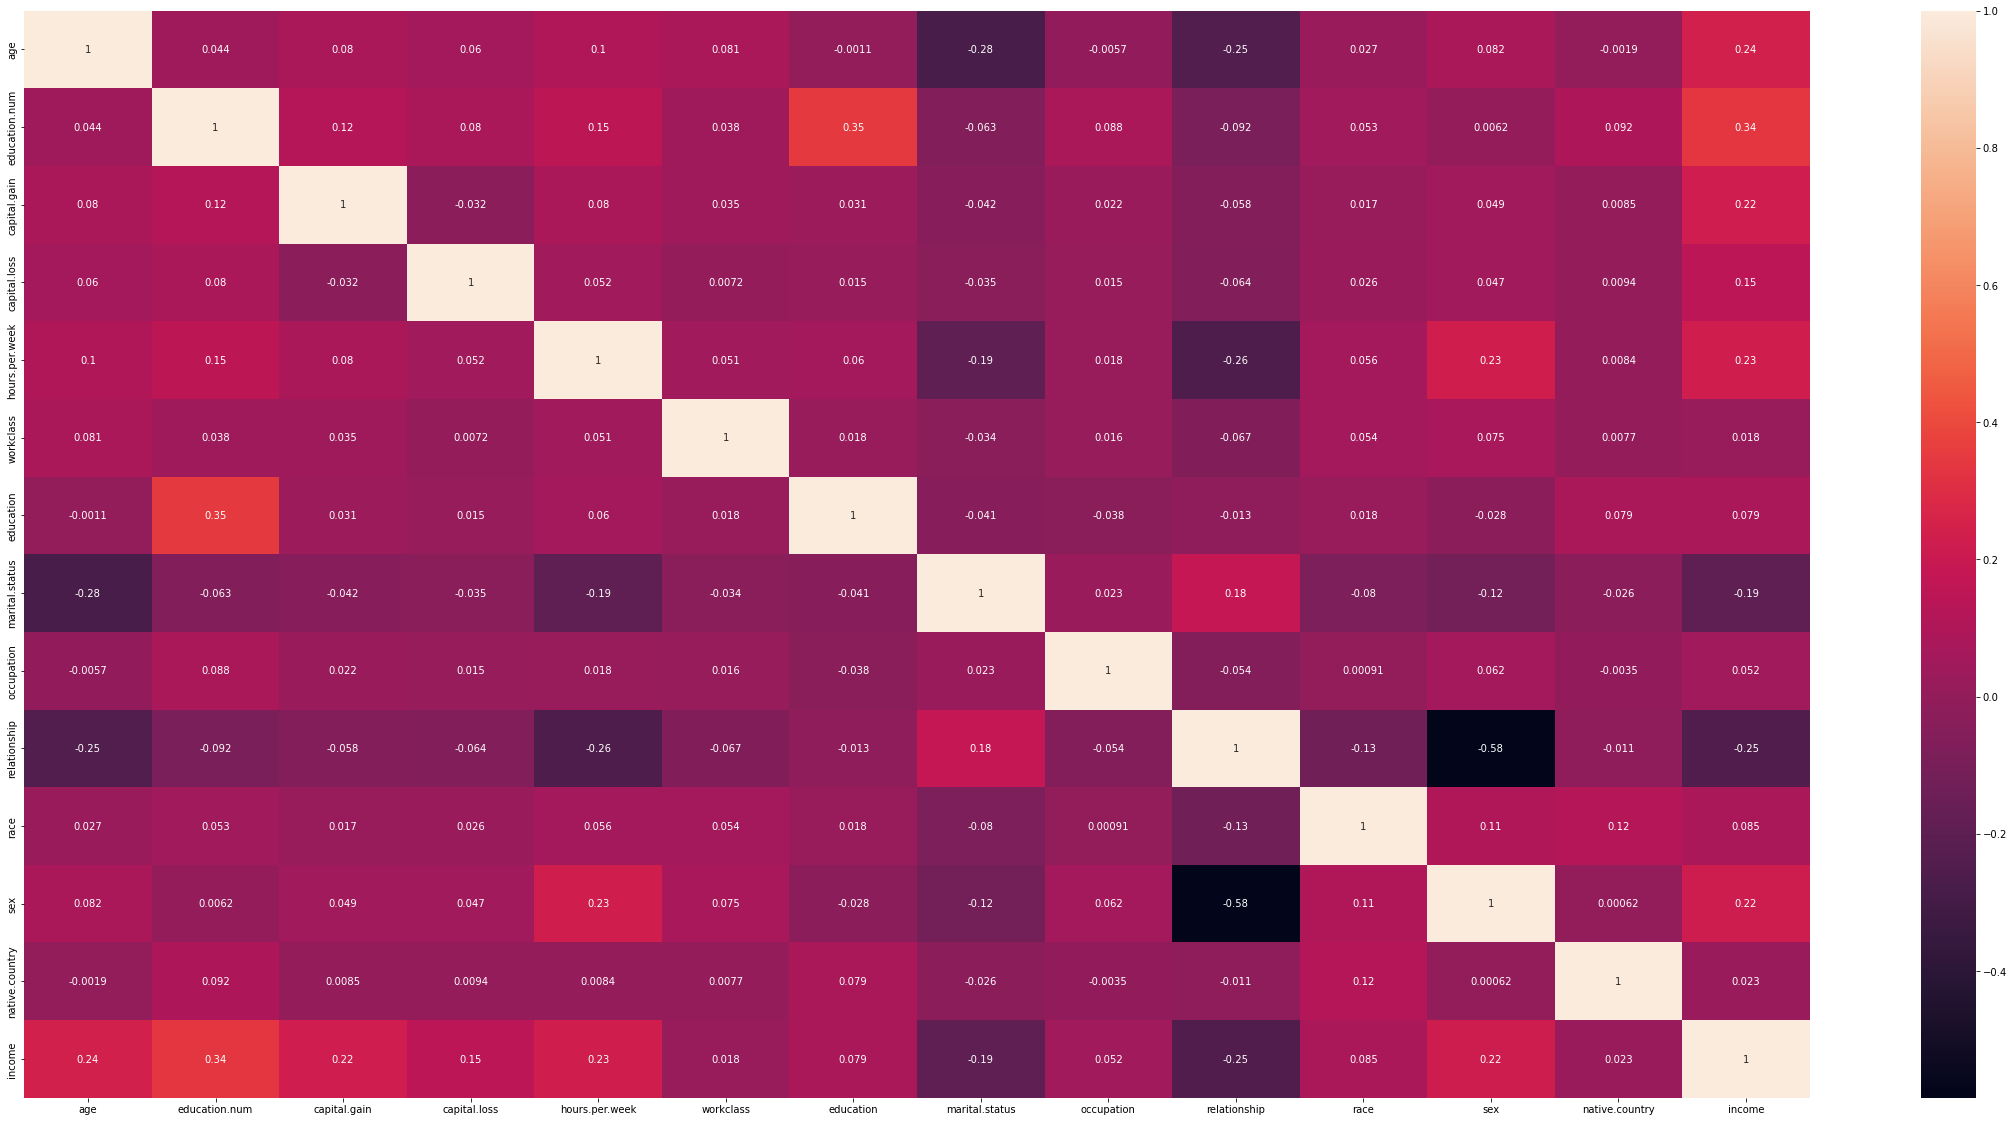

In [13]:
#create Heatmap 
plt.figure(figsize = (40,20))
sns.heatmap(pearson, annot = True)

In [14]:
print(abs(pearson[['sex']]).nlargest(n=9, columns='sex'))

                     sex
sex             1.000000
relationship    0.584876
hours.per.week  0.231268
income          0.216699
marital.status  0.119813
race            0.105148
age             0.081993
workclass       0.074973
occupation      0.062313


In [61]:
target = adult_data.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=22654, Percentage=75.108%
Class=1, Count=7508, Percentage=24.892%


In [62]:
# convert target variable income to categorical
adult_data['income'] = adult_data['income'].astype('category')

In [ ]:
adult_data.info()

In [ ]:
adult_data.head()

In [63]:
#MinMax scalling
scaler = MinMaxScaler()
scaled = scaler.fit_transform(adult_data)
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [64]:
#back to Dataset
adult = pd.DataFrame(scaled,columns = adult_data.columns)
adult.head()                    

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,0.890411,0.533333,0.0,1.000000,0.173469,0.333333,0.733333,1.000000,0.230769,0.2,1.0,0.0,0.95,0.0
1,0.506849,0.200000,0.0,0.895317,0.397959,0.333333,0.333333,0.000000,0.461538,0.8,1.0,0.0,0.95,0.0
2,0.328767,0.600000,0.0,0.895317,0.397959,0.333333,1.000000,0.833333,0.692308,0.6,1.0,0.0,0.95,0.0
3,0.232877,0.533333,0.0,0.865473,0.448980,0.333333,0.733333,0.000000,0.538462,0.8,1.0,0.0,0.95,0.0
4,0.287671,0.333333,0.0,0.865473,0.397959,0.333333,0.000000,0.833333,0.000000,0.8,1.0,1.0,0.95,0.0


In [65]:
adult['income']= adult['income'].apply(np.int64)

In [66]:
# Putting independent variables/features to X
X = adult.drop('income',axis=1)
# Putting response/dependent variable/feature to y
y = adult['income']


In [67]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

#privileged_groups = [{'sex' :1}]
#unprivileged_groups = [{'sex' :0}]

privileged_groups = [{'race' :1}]
unprivileged_groups = [{'race' : 0}]

In [25]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30162 non-null  float64
 1   education.num   30162 non-null  float64
 2   capital.gain    30162 non-null  float64
 3   capital.loss    30162 non-null  float64
 4   hours.per.week  30162 non-null  float64
 5   workclass       30162 non-null  float64
 6   education       30162 non-null  float64
 7   marital.status  30162 non-null  float64
 8   occupation      30162 non-null  float64
 9   relationship    30162 non-null  float64
 10  race            30162 non-null  float64
 11  sex             30162 non-null  float64
 12  native.country  30162 non-null  float64
 13  income          30162 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 3.2 MB


In [26]:
adult.head(10)

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,0.890411,0.533333,0.0,1.000000,0.173469,0.333333,0.733333,1.000000,0.230769,0.2,1.0,0.0,0.95,0
1,0.506849,0.200000,0.0,0.895317,0.397959,0.333333,0.333333,0.000000,0.461538,0.8,1.0,0.0,0.95,0
2,0.328767,0.600000,0.0,0.895317,0.397959,0.333333,1.000000,0.833333,0.692308,0.6,1.0,0.0,0.95,0
3,0.232877,0.533333,0.0,0.865473,0.448980,0.333333,0.733333,0.000000,0.538462,0.8,1.0,0.0,0.95,0
4,0.287671,0.333333,0.0,0.865473,0.397959,0.333333,0.000000,0.833333,0.000000,0.8,1.0,1.0,0.95,0
5,0.780822,1.000000,0.0,0.845500,0.193878,0.833333,0.666667,0.666667,0.692308,0.4,1.0,0.0,0.95,1
6,0.698630,0.533333,0.0,0.845500,0.397959,0.000000,0.733333,0.000000,0.692308,0.2,1.0,0.0,0.95,0
7,0.383562,1.000000,0.0,0.689624,0.346939,0.333333,0.666667,0.000000,0.692308,0.8,0.0,0.0,0.95,1
8,0.287671,0.933333,0.0,0.648301,0.448980,0.666667,0.933333,0.666667,0.692308,0.2,1.0,1.0,0.95,1
9,0.479452,0.800000,0.0,0.648301,0.193878,0.333333,0.600000,1.000000,0.538462,0.2,1.0,0.0,0.95,1


In [68]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= adult,
    label_names = ['income'],
    protected_attribute_names=['race'])

In [69]:
#SPD without classification
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
# Load and create explainers

text_exp_otr = MetricTextExplainer(metric_orig_train)
# Print statistical parity difference
print(text_exp_otr.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.10552461630643828


In [70]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = -0.105525


In [39]:
# Fitting the decision tree with the best hyperparameters after doing GridSearch
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':range(2,20)}
dt_default = GridSearchCV(DecisionTreeClassifier(), tree_param)
dt_default.fit(X_train,y_train)

print('Best score: {}'.format(dt_default.best_score_))
print('Best parameters: {}'.format(dt_default.best_params_))


Best score: 0.854294502982253
Best parameters: {'criterion': 'gini', 'max_depth': 7}


In [40]:
#find the best parameters for the classifier and fit it to the data 
dt_best = DecisionTreeClassifier(criterion= 'gini', max_depth= 7)
dt_best.fit(X_train,y_train)
# making predictions
y_pred_default = dt_best.predict(X_test)

In [41]:
#Compute accuracy
from sklearn import metrics
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
# Printing classifier report after prediction
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, y_pred_default)))


Accuracy Score is: 0.845245988595677


In [ ]:
#Print classification report and confussion matrix
print(classification_report(y_test, y_pred_default))

print(confusion_matrix(y_test, y_pred_default))

In [ ]:
#cross validation with 10 folds and mean accuracy 
cross_val_score(dt_best, X, y, cv = 10).mean()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = DecisionTreeClassifier(criterion= 'gini', max_depth= 9).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

In [ ]:
#pipeline with Standarization, Classifier and cross validation with 10 folds
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(),DecisionTreeClassifier(criterion= 'gini', max_depth= 9))
cross_val_score(clf, X, y, cv=10).mean()


In [ ]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

In [ ]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= X_test,
    label_names=['income'],
    protected_attribute_names=['sex'])

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset, y_pred_default):
    dataset_pred = binaryLabelDataset.copy()
    dataset_pred.labels = y_pred_default
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset, y_pred_default)

In [71]:
# list of models
models = [LogisticRegression(max_iter=500), SVC(kernel='linear'), KNeighborsClassifier(), RandomForestClassifier(), GaussianNB()]

In [72]:
#function for comparing the accuracy of 4 classifiers after 10-fold cross validation
def compare_models_cross_validation():

  for model in models:

    cv_score = cross_val_score(model, X,y, cv=10)
    
    mean_accuracy = sum(cv_score)/len(cv_score)

    mean_accuracy = mean_accuracy*100

    mean_accuracy = round(mean_accuracy, 2)

    print('Cross Validation accuracies for ', model, '=  ', cv_score)
    print('Accuracy % of the ', model, mean_accuracy )
    print('----------------------------------------------')

In [73]:
#Execute the function
compare_models_cross_validation()

Cross Validation accuracies for  LogisticRegression(max_iter=500) =   [0.74875704 0.9350348  0.85875332 0.78614058 0.78448276 0.79476127
 0.79277188 0.78680371 0.79343501 0.78083554]
Accuracy % of the  LogisticRegression(max_iter=500) 80.62
----------------------------------------------
Cross Validation accuracies for  SVC(kernel='linear') =   [0.63208485 0.96884322 0.87732095 0.76757294 0.75994695 0.75895225
 0.76094164 0.76193634 0.75862069 0.7632626 ]
Accuracy % of the  SVC(kernel='linear') 78.09
----------------------------------------------
Cross Validation accuracies for  KNeighborsClassifier() =   [0.7978124  0.83162082 0.80802387 0.80470822 0.80072944 0.81100796
 0.82460212 0.816313   0.81962865 0.80503979]
Accuracy % of the  KNeighborsClassifier() 81.19
----------------------------------------------
Cross Validation accuracies for  RandomForestClassifier() =   [0.57308585 0.91945641 0.70026525 0.79244032 0.80503979 0.80338196
 0.82393899 0.81366048 0.8285809  0.80570292]
Accur

In [74]:
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [75]:
print(grid_search.best_params_)

{'n_neighbors': 29}


In [76]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=29)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [ ]:
#Specifity and Sensitivity
Sensitivity_recall = metrics.recall_score(y_test, y_pred_default)
Specificity =  metrics.recall_score(y_test, y_pred_default, pos_label=0)
#true negatives and true positives
tpr=np.sum((y_pred_default.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_pred_default.ravel()==1)
tnr=np.sum((y_pred_default.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_pred_default.ravel()==0)
#Print metrics
print({"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity})
print("True positive rate =",tpr)  
print("True negative rate =",tnr)

In [77]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
20752,0.452055,0.533333,0.0,0.000000,0.551020,0.333333,0.733333,0.333333,0.846154,0.0,1.0,1.0,0.95,1
13077,0.315068,0.533333,0.0,0.000000,0.397959,0.333333,0.733333,0.333333,0.153846,0.0,0.0,1.0,0.95,0
7786,0.547945,0.600000,0.0,0.000000,0.479592,0.000000,1.000000,0.000000,0.692308,0.2,1.0,1.0,0.95,1
16512,0.232877,0.533333,0.0,0.000000,0.397959,0.333333,0.733333,0.000000,0.000000,0.2,1.0,0.0,0.95,0
28388,0.438356,0.600000,0.0,0.000000,0.397959,0.333333,1.000000,0.333333,1.000000,0.0,1.0,1.0,0.95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22175,0.602740,0.533333,0.0,0.000000,0.193878,0.500000,0.733333,0.333333,0.230769,0.0,1.0,1.0,0.95,1
432,0.315068,0.666667,0.0,0.453857,0.142857,0.666667,0.533333,0.333333,0.692308,1.0,1.0,0.0,0.95,1
27631,0.520548,0.800000,0.0,0.000000,0.448980,0.333333,0.600000,0.333333,0.230769,0.0,1.0,1.0,0.95,1
16428,0.164384,0.466667,0.0,0.000000,0.397959,0.333333,0.133333,0.500000,0.538462,0.2,0.0,0.0,0.95,0


In [78]:
binaryLabelDataset2 = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= X_test,
    label_names=['income'],
    protected_attribute_names=['race'])

In [80]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

dataset = StandardDataset(X_test, 
                          label_name='income', 
                          favorable_classes=[1], 
                          protected_attribute_names=['race'], 
                          privileged_classes=[[1]])

def fair_metrics(dataset, y_pred):
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference(),
             'disparate_impact': metric_pred.disparate_impact(),
             'equal_opportunity_difference': classified_metric.equal_opportunity_difference()}
        
    return result


fair_metrics(dataset, y_pred)

{'statistical_parity_difference': -0.13561231168068305,
 'disparate_impact': 0.4033427048284291,
 'equal_opportunity_difference': -0.27513432292140977}

In [82]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset2, y_pred):
    dataset_pred = binaryLabelDataset2.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset2, y_pred)

{'statistical_parity_difference': -0.13561231168068305}

In [35]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset2,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = -0.186910


In [ ]:
# Printing classifier report after prediction
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, y_pred_default)))

In [43]:
#function for comparing accuracy of 4 classifiers 
#test_data_prediction = []
def compare_models_train_test():

  for model in models:

    # training the model
    model.fit(X_train, y_train)
    
    # evaluating the model
    test_data_prediction = model.predict(X_test)

    accuracy = accuracy_score(y_test, test_data_prediction)

    print('Accuracy score of the ', model, ' = ', accuracy)

In [44]:
#Execute the def
compare_models_train_test()

Accuracy score of the  LogisticRegression(max_iter=500)  =  0.8246916854528578
Accuracy score of the  SVC(kernel='linear')  =  0.8232329929717545
Accuracy score of the  KNeighborsClassifier()  =  0.8273438536003183
Accuracy score of the  RandomForestClassifier()  =  0.8489590240021218
Accuracy score of the  GaussianNB()  =  0.8029439066436812
